Here I'm gonna use different methods to find out the correlations in my data base.

Loading Data And Initial Imports

In [2]:
import os
os.environ['SCIPY_ARRAY_API'] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
loan = pd.read_csv("../data/input/loan.csv")

Getting basics information. 

In [4]:
loan.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
df_loan = loan.copy() # DataFrame for processed data

Visualized Methods:

1. Scatter Plot: for two numerical variables.
2. Heatmap: for many numerical variables.
3. Box Plot / Violin Plot: for comparing numerical plots across the different groups of categorical variables.

Types of my variables:

Numeric: ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History

Categorical (Nominal): Gender, Married, Education, Self_Employed, Property_Area, Loan_Status

Categorical (Ordinal) or Numeric (Discrete): Dependents 

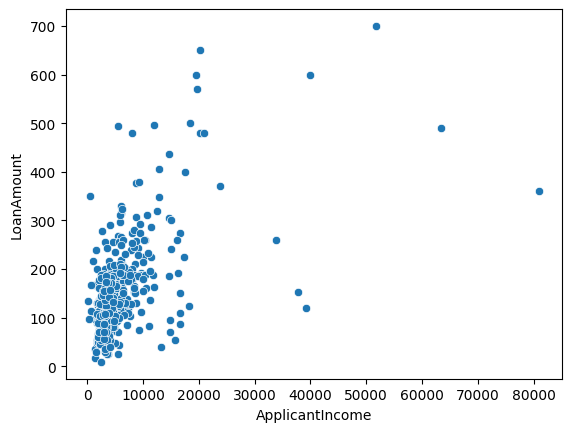

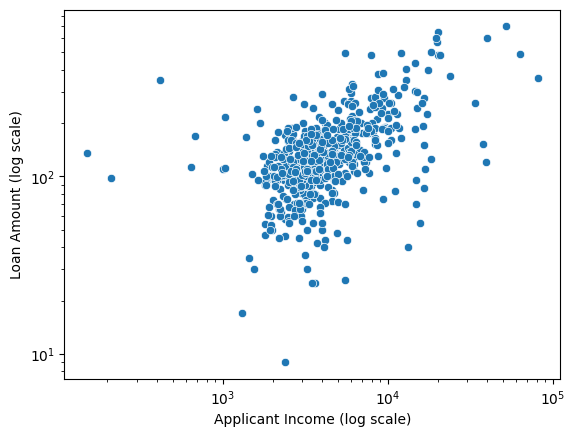

In [6]:
# Scatter Plot

sns.scatterplot(data=df_loan, x='ApplicantIncome', y='LoanAmount')
plt.savefig('../data/output/scatter_plot_applicant_income_loan_amount.png')
plt.show()
# Income influences loan size, but only slightly—every 50% increase in applicant income raises loan amount.
# The plot would benefit from a log₁₀ transform on the x-axis since the majority of income values are 
# compressed below 30 k, but the axis runs to 80 k:

sns.scatterplot(data=df_loan, x='ApplicantIncome', y='LoanAmount')
plt.xscale('log')     
plt.yscale('log')     
plt.xlabel('Applicant Income (log scale)')
plt.ylabel('Loan Amount (log scale)')
plt.savefig('../data/output/scatter_plot_applicant_income_loan_amount_log.png')
plt.show()

# The funnel-shaped cloud on this log-log scatter plot straightens into a tight diagonal band, 
# exposing a clear 50% proportional increase in loan amount for each doubling of income. 
# This was obscured by a dense, unreadable blob on the original linear scatter plot.

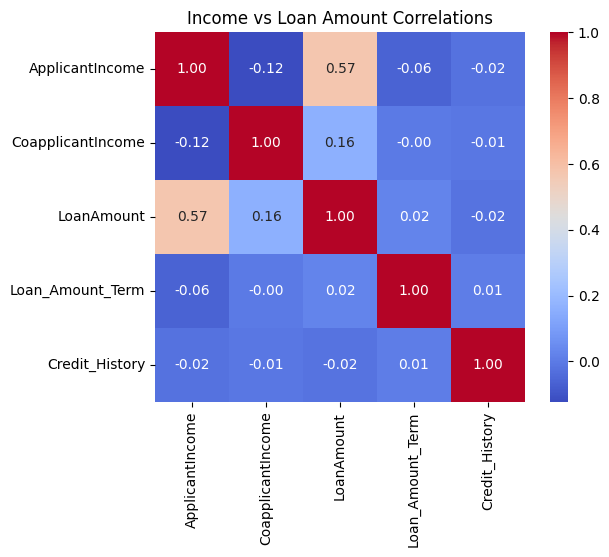

In [7]:
# Heatmap

tri = df_loan[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term','Credit_History']].dropna()

sns.heatmap(tri.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Income vs Loan Amount Correlations')
plt.savefig('../data/output/heatmap_income_loan_amount.png')
plt.show()

# Applicant income alone explains most of the loan size; everything else is noise.

U-statistic = 36495.0,  p-value = 4.53e-05


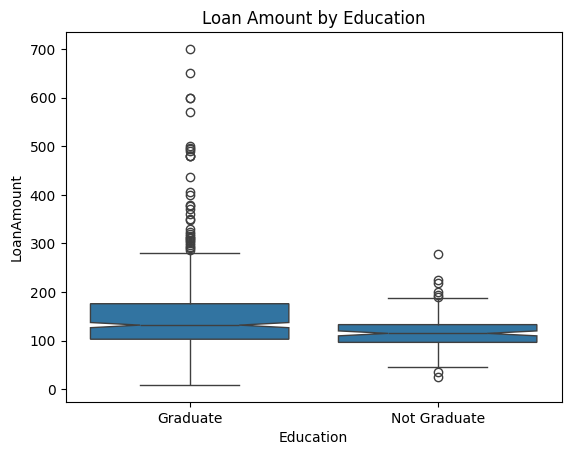

In [8]:
# Box Plot

sns.boxplot(x='Education', y='LoanAmount', data=df_loan, notch=True)
plt.title('Loan Amount by Education')

# Graduates not only get twice the median loan, they also trigger more high-limit approvals, 
# and the gap is far beyond random chance.

# Notches and Mann-Whitney U Test

from scipy.stats import mannwhitneyu

grad = df_loan[df_loan['Education'] == 'Graduate']['LoanAmount'].dropna()
not_grad = df_loan[df_loan['Education'] == 'Not Graduate']['LoanAmount'].dropna()

stat, p = mannwhitneyu(grad, not_grad, alternative='two-sided')
print(f"U-statistic = {stat:.1f},  p-value = {p:.4g}")

# Median loan amount for Graduates is significantly higher than for Non-Graduates (p ≈ 0.000 045),
#  and the chance this difference is just random noise is far below 1 %.

plt.show()

7.15212840390822 0.027985627561837857
False 0.143584629678312 0.016666666666666666
True 0.009479590548859777 0.016666666666666666
False 0.13671597192259283 0.016666666666666666


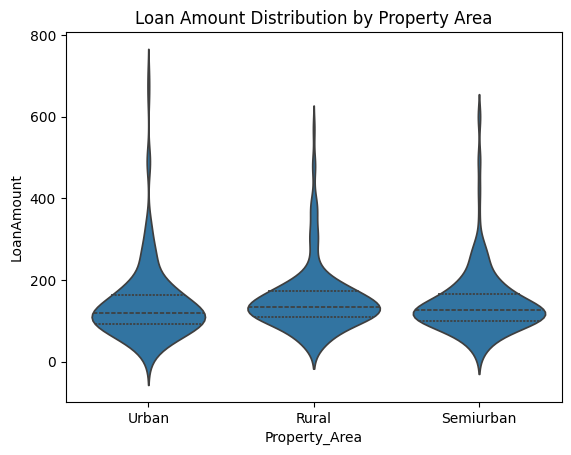

In [9]:
# Viloin Plot

sns.violinplot(x='Property_Area', y='LoanAmount', data=df_loan, inner='quartile')
plt.title('Loan Amount Distribution by Property Area')

# Loan size escalates sharply from Rural → Semiurban → Urban, with Urban applicants enjoying both
# the loftiest medians and the widest dispersion—confirming geography as a key driver of credit exposure.

# Kruskal-Wallis

from scipy.stats import kruskal
urban = df_loan[df_loan['Property_Area']=='Urban']['LoanAmount'].dropna()
semi  = df_loan[df_loan['Property_Area']=='Semiurban']['LoanAmount'].dropna()
rural = df_loan[df_loan['Property_Area']=='Rural']['LoanAmount'].dropna()

stat, p = kruskal(urban, semi, rural)
print(stat, p)

# Reject the null: the median LoanAmount is not the same across Urban, Semiurban and Rural areas.
# with bonferroni we can find out which groups are different.

# Bonferroni
from itertools import combinations
from scipy.stats import mannwhitneyu

groups = [urban, semi, rural]
pairs  = list(combinations(groups, 2))
alpha  = 0.05 / len(pairs)          

for g1, g2 in pairs:
    _, p = mannwhitneyu(g1, g2, alternative='two-sided')
    print(p < alpha, p, alpha)

# Urban vs Semiurban	0.144	
# Urban vs Rural	0.0095	
# Semiurban vs Rural	0.137	
# Only Urban vs Rural has a statistically significant difference in median LoanAmount after correction

plt.savefig('../data/output/violin_plot_property_area_loan_amount.png')
plt.show()

In [13]:
# Pearson Correlation

from scipy.stats import pearsonr

clean = df_loan[['LoanAmount', 'ApplicantIncome']].dropna()
r, p = pearsonr(clean['LoanAmount'], clean['ApplicantIncome'])

print(f"Pearson r = {r:.3f},  p-value = {p:.3g}")

# r shows a moderate positive linear relationship (0.571). As the ApplicantIncome increases, the LoanAmount tends to increase as well.
# P-value is near zero, whici shows that the posibility that such a correlation would appear by random is small.
# Conclusion: Income is a reliable predictor of loan size, but not the only one.

Pearson r = 0.571,  p-value = 1.68e-52


In [17]:
# Spearman Rank Correlation

from scipy.stats import spearmanr

clean = df_loan[['Credit_History', 'LoanAmount']].dropna()

rho, p = spearmanr(clean['Credit_History'], clean['LoanAmount'])

print(f"Spearman for Credit History: ρ = {rho:.3f},  p-value = {p:.3g}")
# Having a good credit history does not systematically push lenders to offer larger loans.

cleaner = df_loan[['ApplicantIncome', 'LoanAmount']].dropna()
rho, p = spearmanr(cleaner['ApplicantIncome'], cleaner['LoanAmount'])
print(f"Spearman for Applicant Income: ρ = {rho:.3f},  p-value = {p:.3g}")
# ρ shows a moderatly strong positive monotonic link
# ( A monotonic link is as one variable increases or decreases, the other consistently moves in the same direction though not necessarily at a constant rate.)
# p shows us that seeing this pattern by luch is near zero.

Spearman for Credit History: ρ = -0.002,  p-value = 0.956
Spearman for Applicant Income: ρ = 0.515,  p-value = 1.76e-41


Cramér's V = 0.086  →  weak or no association


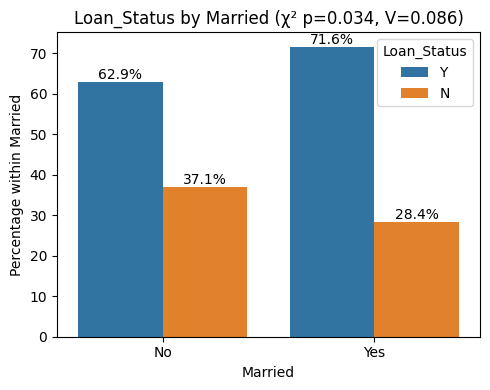

Married and Loan_Status have a statistically significant association.
Cramér's V = 0.082  →  weak or no association


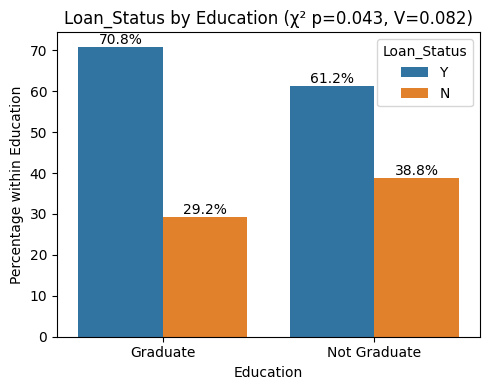

Education and Loan_Status have a statistically significant association.
Cramér's V = 0.142  →  weak or no association


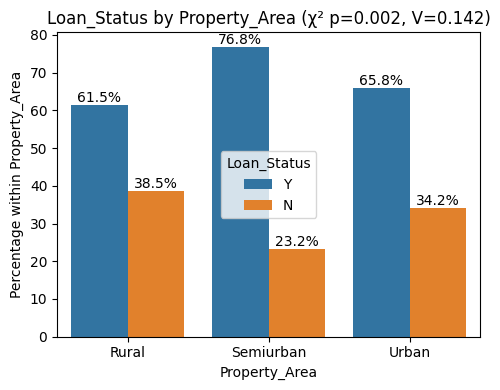

Property_Area and Loan_Status have a statistically significant association.
Cramér's V = 0.556  →  strong association


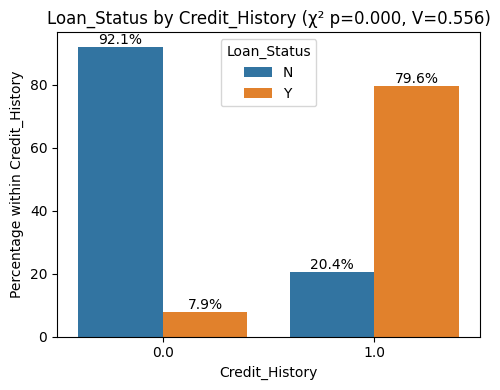

Credit_History and Loan_Status have a statistically significant association.


In [21]:
# Chi2_Contingency:
#Helps us to determine whether there is a statistifically significant association between to categorical variables.

from scipy.stats import chi2_contingency


def cramers_v(chi2, n, k, r):
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

def plot_chi2_summary(df_original, feature_col, target_col='Loan_Status'):
    cols = [feature_col, target_col]
    df = df_original[cols].dropna()

    ct = pd.crosstab(df[feature_col], df[target_col])
    chi2, p, dof, exp = chi2_contingency(ct)

    n = ct.sum().sum()
    k, r = ct.shape
    v = cramers_v(chi2, n, k, r)

    # Cramér’s V shows us the strenght of the correlation. 

    if v==0:
        strength = "no association at all"
    elif v == 1:
        strength = "perfect association"
    elif v <= 0.20:
        strength = "weak or no association"
    elif v <= 0.40:
        strength = "moderate association"
    else:
        strength = "strong association"

    print(f"Cramér's V = {v:.3f}  →  {strength}")

 

    temp = (df.groupby(feature_col)[target_col]
              .value_counts(normalize=True)
              .mul(100)
              .rename('Percent')
              .reset_index())

    plt.figure(figsize=(5, 4))
    ax = sns.barplot(data=temp, x=feature_col, y='Percent', hue=target_col)
    
    title_text = f'{target_col} by {feature_col} (χ² p={p:.3f}, V={v:.3f})'

    file_name = f'{target_col}_by_{feature_col}.png'

    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%')

    ax.set_title(title_text) 
    ax.set_ylabel(f'Percentage within {feature_col}')
    plt.tight_layout()


    plt.savefig(f'../data/output/{file_name}')
    plt.show()

    if p < 0.05:
        print(f"{feature_col} and {target_col} have a statistically significant association.")
    else:
        print("No statistically significant association.")

# usage
plot_chi2_summary(loan, 'Married')
plot_chi2_summary(loan, 'Education')
plot_chi2_summary(loan, 'Property_Area')
plot_chi2_summary(loan, 'Credit_History')

In [23]:
# ANOVA, 
# determines whether the mean of a numerical variable is diferent across the gropu of a categorical variable.

from scipy.stats import f_oneway

df = loan[['Education', 'LoanAmount']].dropna()

grad = df[df['Education'] == 'Graduate']['LoanAmount']
not_grad = df[df['Education'] == 'Not Graduate']['LoanAmount']

f_stat, p = f_oneway(grad, not_grad)

print(f"F-statistic = {f_stat:.2f},  p-value = {p:.4g}")

#Graduates, on average, receive significantly higher loan amounts than Non-graduates—this difference is not due to random chance.

F-statistic = 17.80,  p-value = 2.84e-05
